In [1]:
from spectral import *
import spectral.io.envi as envi
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

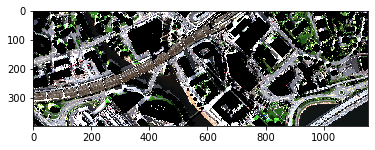

In [2]:
image = envi.open('../../hyperImage/stacked/ref/09_training_masked.hdr', '../../hyperImage/stacked/ref/09_training_masked.')
img = image.load()
view = imshow(img, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)))

In [67]:
img.shape

(397, 1153, 474)

In [ ]:
#compute PCA on the image 
pc = principal_components(image)
pc_0999 = pc.reduce(fraction=0.999)
img_pc = pc_0999.transform(image)
img_pc.shape

In [ ]:
#NDVI calculation of the image 
vi = ndvi(image, 76, 105)
data_ndvi = np.nan_to_num(vi)

In [ ]:
## Combine PCA,and ndvi DATA
pc_img = img_pc.load()
df_pca = pd.DataFrame(pc_img.reshape(-1, img_pc.shape[2]))
string = "PC"
df_pca.columns = [string + str(n) for n in range(1, img_pc.shape[2]+1)]
df_ndvi = pd.DataFrame(data_ndvi.reshape(-1, 1))
string = "NDVI"
df_ndvi.columns = [string]
#Concatenate 3 dataframe 
main_df = pd.concat([df_pca, df_ndvi], axis=1, sort=False)

In [ ]:
main_df.to_csv('../../hyperImage/csv/features/Stacked_HSI_feature2', index=False)



In [3]:
main_df = pd.read_csv('../../hyperImage/csv/features/Stacked_HSI_feature2')

<function matplotlib.pyplot.show(*args, **kw)>

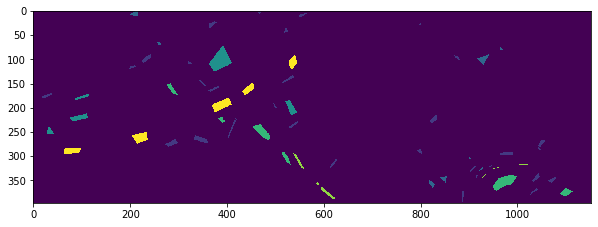

In [4]:
## Class image
gt_data = Image.open('../../hyperImage/stacked/ref/classref.tif')
gt = np.array(gt_data)
plt.figure(figsize=(10, 10))
plt.imshow(gt)
plt.show

In [5]:
np.unique(gt)

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

In [6]:
df_class = pd.DataFrame(gt.reshape(-1, 1))
string = "Target"
df_class.columns = [string]

# Using only hyperspectral data 

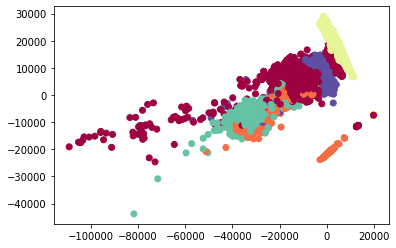

In [7]:
df = pd.concat([main_df, df_class], axis=1, sort=False)
df_masked = df[(df[['Target']] != 0). all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Spectral')
plt.show()

In [8]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)

In [75]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [6, 7],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [10]:
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(y_test, pred)

0.9928057553956835

In [12]:
clf = SVC(gamma='auto')
clf.fit(X_scaled, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [13]:
X_data = df.drop(columns=['Target']).values
X_data_scaled = scaler.transform(X_data)

In [14]:
y_pred = clf.predict(X_data_scaled)

In [15]:
predicted_hsi_mask = y_pred.reshape(img.shape[0], img.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1416.0]
    G: [0.0, 1295.0]
    B: [0.0, 1032.0]
>

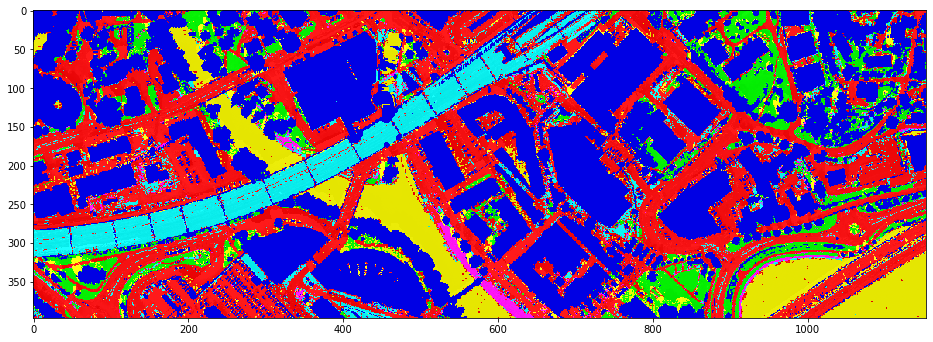

In [16]:
#full_image = envi.open('../hyperImage/09_full_image.hdr', '../hyperImage/09_full_image.')
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_mask)
view.set_display_mode('overlay')
view.class_alpha = 0.9
view.show_data

In [17]:
road = (predicted_hsi_mask == 1).astype(int)

In [18]:
from skimage.feature import canny
from skimage.viewer import ImageViewer
from skimage import io
from skimage import img_as_uint
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.3,
)
#viewer = ImageViewer(edges)
#viewer.show()
road_edges = edges.astype(int)



/opt/anaconda3/lib/python3.7/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1416.0]
    G: [0.0, 1295.0]
    B: [0.0, 1032.0]
>

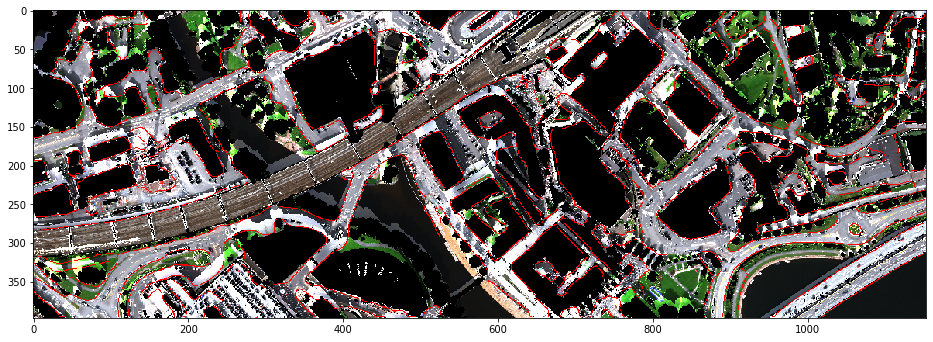

In [19]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Validation

In [20]:
val_image = envi.open('../../hyperImage/stacked/ref/validation/08_vali_masked.hdr', '../../hyperImage/stacked/ref/validation/08_vali_masked.')
val_img = image.load()
val_img.shape

(397, 1153, 474)

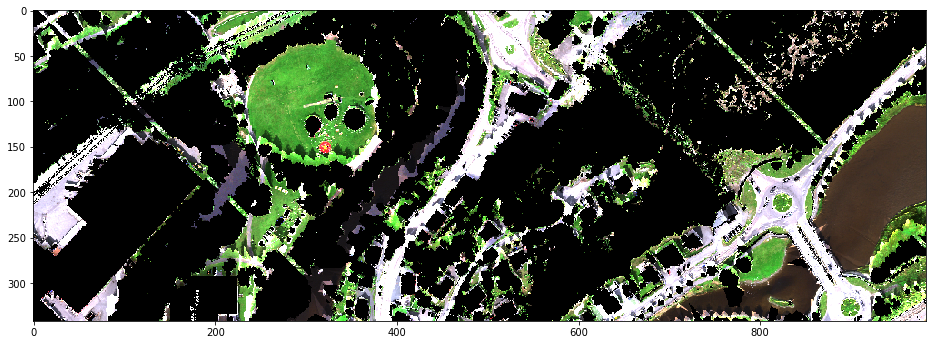

In [21]:
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16))

In [99]:
#compute PCA on the image 
pc = principal_components(val_image)
pc_0999 = pc.reduce(fraction=0.999)
val_img_pc = pc_0999.transform(val_image)
val_img_pc.shape

Covariance.....  0.0Covariance.....  0.0Covariance.....done  


(342, 983, 75)

In [101]:
pc_img = val_img_pc.load()
pc_img = pc_img[:,:, :71]
pc_img.shape

(342, 983, 71)

In [102]:
df_pca = pd.DataFrame(pc_img.reshape(-1, pc_img.shape[2]))
string = "PC"
df_pca.columns = [string + str(n) for n in range(1, pc_img.shape[2]+1)]
main_df_val = pd.concat([df_pca], axis=1, sort=False)

In [103]:
main_df_val.to_csv('../../hyperImage/csv/features/Stacked_HSI_feature_val1', index=False)

In [22]:
main_df_val = pd.read_csv('../../hyperImage/csv/features/Stacked_HSI_feature_val1')

In [23]:
main_df_val

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71
0,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,-3.287200,-1.998465,0.971086,-0.422678,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086
1,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,-3.287200,-1.998465,0.971086,-0.422678,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086
2,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,-3.287200,-1.998465,0.971086,-0.422678,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086
3,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,-3.287200,-1.998465,0.971086,-0.422678,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086
4,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,-3.287200,-1.998465,0.971086,-0.422678,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336181,-10955.795116,6039.595995,4891.547657,-2445.342462,7582.960443,-1434.890131,-476.454318,2015.559349,1909.808587,2430.330381,...,933.696980,546.599195,-305.362058,177.089701,-9.817050,41.928247,-35.437209,5.703321,-27.045144,10.401062
336182,-9836.259876,5022.531363,4769.039880,-3206.856126,6536.374603,-1720.812448,324.660772,930.568527,759.102566,428.407515,...,1031.252843,608.513303,-348.525265,189.734840,-17.334349,40.927541,-21.141926,16.544124,-36.275199,9.149798
336183,-6387.020876,6970.377627,7963.717546,-3436.109274,8568.657306,-3734.720215,3259.079433,-2127.672207,-546.795593,-1668.729675,...,-122.917550,-50.002655,43.431308,8.247761,14.548043,-0.628511,8.716740,11.311020,-24.581857,1.274968
336184,-7049.361874,7138.640258,8891.728496,-3161.313079,8388.955776,-3770.933546,1610.705315,-51.314330,249.440996,-492.486463,...,236.536905,139.441563,-59.327225,45.198406,7.209419,22.115634,7.394622,8.388109,-7.954778,1.574247


In [24]:
#NDVI calculation of the image 
vi = ndvi(val_image, 76, 105)
data_ndvi = np.nan_to_num(vi)

/opt/anaconda3/lib/python3.7/site-packages/spectral/algorithms/algorithms.py:1216: RuntimeWarning: invalid value encountered in true_divide
  return (n - r) / (n + r)


In [25]:
df_ndvi_val = pd.DataFrame(data_ndvi.reshape(-1, 1))
string = "NDVI"
df_ndvi_val.columns = [string]
#Concatenate 3 dataframe 
main_df_val = pd.concat([main_df_val, df_ndvi_val], axis=1, sort=False)

In [26]:
main_df_val_scaled = scaler.transform(main_df_val)
hsi_val_pred = clf.predict(main_df_val_scaled)
predicted_hsi_mask_val = hsi_val_pred.reshape(342, 983)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 849.0]
    G: [0.0, 825.0]
    B: [0.0, 626.0]
>

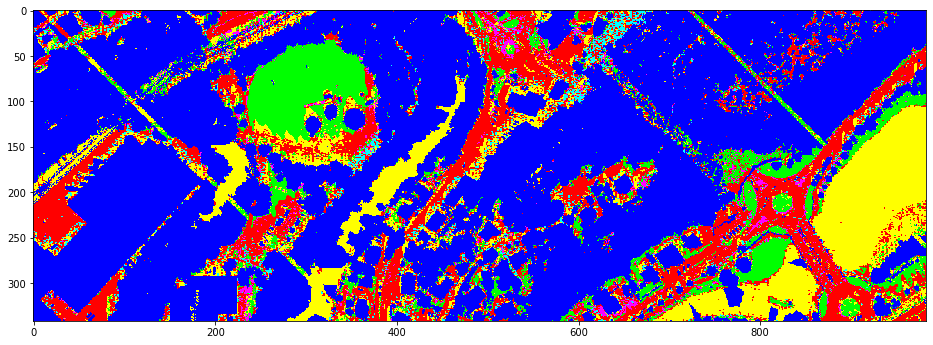

In [27]:
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [28]:
## Class image
gt_data_val = Image.open('../../hyperImage/stacked/ref/validation/val_class.tif')
gt_val = np.array(gt_data_val)
gt_val.shape

(342, 983)

In [29]:
df_class_val = pd.DataFrame(gt_val.reshape(-1, 1))
string = "Target"
df_class_val.columns = [string]
df_class_val.shape

(336186, 1)

In [30]:
df_hsi_val = pd.concat([main_df_val, df_class_val], axis=1, sort=False)

In [31]:
df_hsi_val

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,NDVI,Target
0,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,0.971086,-0.422678,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086,0.000000,0
1,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,0.971086,-0.422678,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086,0.000000,0
2,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,0.971086,-0.422678,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086,0.000000,0
3,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,0.971086,-0.422678,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086,0.000000,0
4,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,0.971086,-0.422678,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336181,-10955.795116,6039.595995,4891.547657,-2445.342462,7582.960443,-1434.890131,-476.454318,2015.559349,1909.808587,2430.330381,...,-305.362058,177.089701,-9.817050,41.928247,-35.437209,5.703321,-27.045144,10.401062,-0.007535,0
336182,-9836.259876,5022.531363,4769.039880,-3206.856126,6536.374603,-1720.812448,324.660772,930.568527,759.102566,428.407515,...,-348.525265,189.734840,-17.334349,40.927541,-21.141926,16.544124,-36.275199,9.149798,0.008403,0
336183,-6387.020876,6970.377627,7963.717546,-3436.109274,8568.657306,-3734.720215,3259.079433,-2127.672207,-546.795593,-1668.729675,...,43.431308,8.247761,14.548043,-0.628511,8.716740,11.311020,-24.581857,1.274968,-0.007376,0
336184,-7049.361874,7138.640258,8891.728496,-3161.313079,8388.955776,-3770.933546,1610.705315,-51.314330,249.440996,-492.486463,...,-59.327225,45.198406,7.209419,22.115634,7.394622,8.388109,-7.954778,1.574247,-0.011854,0


In [32]:
df_hsi_val_masked = df_hsi_val[(df_hsi_val[['Target']] != 0).all(axis=1)]
X_val = df_hsi_val_masked.drop(columns=['Target']).values
y_val = df_hsi_val_masked['Target'].values

In [33]:
X_data_scaled_val = scaler.transform(X_val)
y_pred = clf.predict(X_data_scaled_val)

In [34]:
accuracy_score(y_val, y_pred)

0.7800474291257949

In [35]:
target_names = ['Road', 'Vegetation', 'Soil','Unclassified', 'Water', 'Train Track']
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.91      0.91      0.91      3456
  Vegetation       0.98      0.62      0.76      5566
        Soil       0.58      0.99      0.73      4439
Unclassified       0.94      0.82      0.88      4135
       Water       0.23      0.04      0.07       940
 Train Track       0.07      0.67      0.12        18

    accuracy                           0.78     18554
   macro avg       0.62      0.68      0.58     18554
weighted avg       0.82      0.78      0.77     18554



In [36]:
cohen_kappa_score(y_val, y_pred)

0.7129086802581657

In [37]:
confusion_matrix(y_val, y_pred)

array([[3142,    9,   15,   95,  112,   83],
       [  38, 3463, 1967,   87,    8,    3],
       [   3,    0, 4412,   23,    0,    1],
       [  18,    0,  709, 3407,    1,    0],
       [ 241,   55,  507,   21,   37,   79],
       [   3,    1,    0,    2,    0,   12]])

# Using Lidar Data Only

In [38]:
#import lidar dem and intensity image 
l_intensity_data = Image.open('../../hyperImage/stacked/ref/intensity.tif')
l_intensity = np.array(l_intensity_data)
df_intensity = pd.DataFrame(l_intensity.reshape(-1, 1))
string = "Lidar Intensity"
df_intensity.columns = [string]

l_dsm_data = Image.open('../../hyperImage/stacked/ref/nDSM.tif')
l_dsm = np.array(l_dsm_data)
df_dsm = pd.DataFrame(l_dsm.reshape(-1, 1))
string = "Lidar nDSM"
df_dsm.columns = [string]

In [39]:
df_lidar = pd.concat([df_intensity, df_dsm, df_class], axis=1, sort=False)
df_lidar.to_csv('../../hyperImage/csv/features/Stacked_lidar_features', index=False)

In [40]:
df_lidar = pd.read_csv('../../hyperImage/csv/features/Stacked_lidar_features')

In [41]:
df_lidar

,Lidar Intensity,Lidar nDSM,Target
0,27.0,25.160000,0
1,6.0,23.369999,0
2,7.0,23.279999,0
3,15.0,24.029999,0
4,1.0,21.400000,0
...,...,...,...
457736,12.0,0.050000,0
457737,6.0,0.020000,0
457738,13.0,0.020000,0
457739,9.0,0.060000,0


In [42]:
df_lidar_masked =  df_lidar[(df_lidar[['Target']] != 0). all(axis=1)]
X = df_lidar_masked.drop(columns=['Target']).values
y = df_lidar_masked['Target'].values

In [43]:
scaler1 = StandardScaler()
scaler1.fit(X)
X_scaled = scaler1.transform(X)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)

In [45]:
clf1 = SVC(gamma='auto')
clf1.fit(X_train, y_train)
pred = clf1.predict(X_test)
accuracy_score(y_test, pred)

0.6360366252452584

In [46]:
clf1 = SVC(gamma='auto')
clf1.fit(X_scaled, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [47]:
X_lidar_data = df_lidar.drop(columns=['Target']).values
S_lidar_data_scaled = scaler1.transform(X_lidar_data)
y_pred_lidar = clf1.predict(S_lidar_data_scaled)
predicted_lidar_mask = y_pred_lidar.reshape(img.shape[0], img.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1416.0]
    G: [0.0, 1295.0]
    B: [0.0, 1032.0]
>

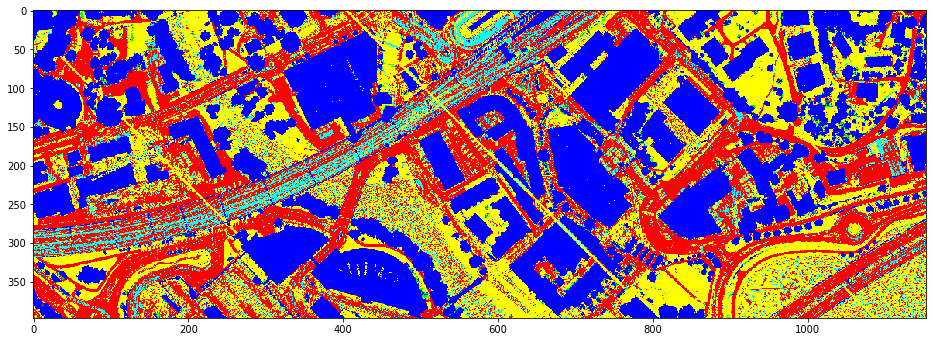

In [48]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [49]:
road = (predicted_lidar_mask == 1).astype(int)

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.3,
)

road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1416.0]
    G: [0.0, 1295.0]
    B: [0.0, 1032.0]
>

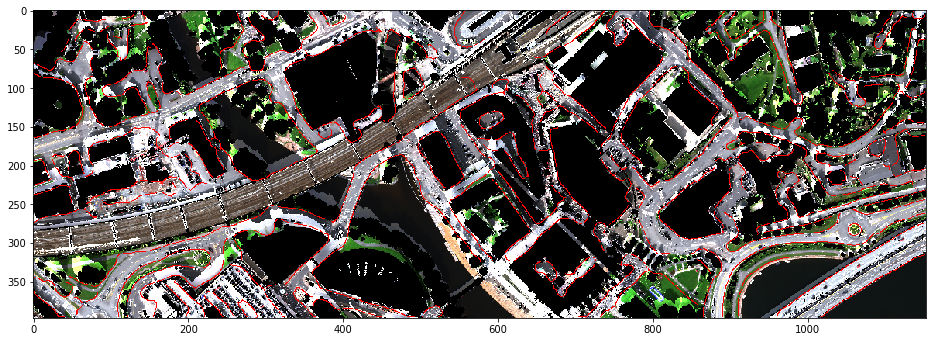

In [51]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

## Validation

In [145]:
#import lidar dem and intensity image 
l_intensity_data = Image.open('../../hyperImage/stacked/ref/validation/intensity.tif')
l_intensity = np.array(l_intensity_data)
df_intensity = pd.DataFrame(l_intensity.reshape(-1, 1))
string = "Lidar Intensity"
df_intensity.columns = [string]

l_dsm_data = Image.open('../../hyperImage/stacked/ref/validation/nDSM.tif')
l_dsm = np.array(l_dsm_data)
df_dsm = pd.DataFrame(l_dsm.reshape(-1, 1))
string = "Lidar nDSM"
df_dsm.columns = [string]

In [147]:
l_intensity.shape

(342, 983)

In [139]:
df_lidar_val = pd.concat([df_intensity, df_dsm], axis=1, sort=False)
df_lidar_val.to_csv('../../hyperImage/csv/features/Stacked_lidar_features_val1', index=False)

In [52]:
df_lidar_val = pd.read_csv('../../hyperImage/csv/features/Stacked_lidar_features_val1')

In [53]:
df_lidar_val

,Lidar Intensity,Lidar nDSM
0,16.0,29.960000
1,15.0,29.940000
2,16.0,29.940000
3,19.0,29.910000
4,17.0,29.920000
...,...,...
336181,23.0,0.009999
336182,25.0,0.010000
336183,23.0,0.090000
336184,19.0,0.040001


In [54]:
X_data_val_scaled = scaler1.transform(df_lidar_val.values)
y_pred = clf1.predict(X_data_val_scaled)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 849.0]
    G: [0.0, 825.0]
    B: [0.0, 626.0]
>

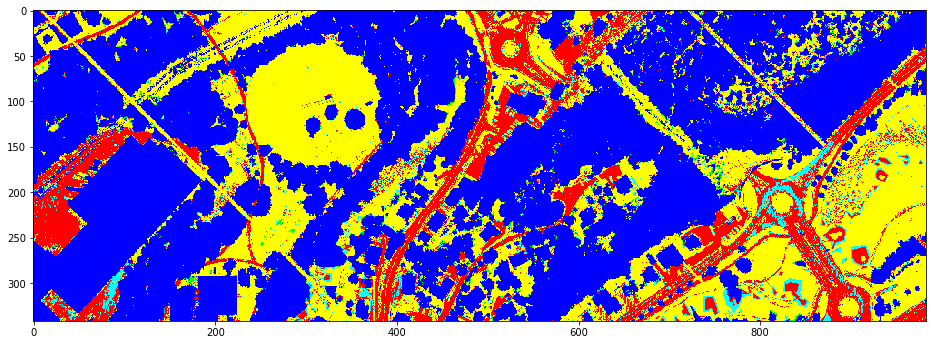

In [55]:
predicted_lidar_mask = y_pred.reshape(342, 983)
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [56]:
df_lidar_val = pd.concat([df_lidar_val, df_class_val], axis=1, sort=False)

In [57]:
df_lidar_val_masked = df_lidar_val[(df_lidar_val[['Target']] != 0).all(axis=1)]
X_val = df_lidar_val_masked.drop(columns=['Target']).values
y_val = df_lidar_val_masked['Target'].values

In [58]:
X_data_scaled_val = scaler1.transform(X_val)
y_pred = clf1.predict(X_data_scaled_val)

In [59]:
accuracy_score(y_val, y_pred)

0.5324997305163307

In [60]:
target_names = ['Road', 'Vegetation', 'Water','Unclassified', 'Soil', 'Train Track']
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.83      0.84      0.84      3456
  Vegetation       0.02      0.00      0.00      5566
       Water       0.60      0.98      0.75      4439
Unclassified       0.38      0.63      0.48      4135
        Soil       0.00      0.00      0.00       940
 Train Track       0.00      0.00      0.00        18

    accuracy                           0.53     18554
   macro avg       0.30      0.41      0.34     18554
weighted avg       0.39      0.53      0.44     18554



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
confusion_matrix(y_val, y_pred)

array([[2917,    0,    4,  172,    0,  363],
       [  36,    1, 1941, 3570,    0,   18],
       [  39,   11, 4343,   38,    0,    8],
       [ 478,   23,  522, 2619,    0,  493],
       [  47,   26,  392,  431,    0,   44],
       [  12,    0,    0,    6,    0,    0]])

In [62]:
cohen_kappa_score(y_val, y_pred)

0.4071456789010143

# Using fused hyperspectral and lidar data 

# merge with HSI dataframe and lidar dataframe

In [63]:
df_lid_hsi = pd.concat([main_df, df_lidar], axis=1, sort=False)

In [64]:
df_lid_hsi

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC66,PC67,PC68,PC69,PC70,PC71,NDVI,Lidar Intensity,Lidar nDSM,Target
0,19835.212752,-7436.564557,-1792.510832,-8.205872,629.721888,-287.834992,-25.252261,-68.652420,121.965378,33.196618,...,-0.260596,-0.165326,0.143836,0.160995,0.215499,-0.949303,0.000000,27.0,25.160000,0
1,19835.212752,-7436.564557,-1792.510832,-8.205872,629.721888,-287.834992,-25.252261,-68.652420,121.965378,33.196618,...,-0.260596,-0.165326,0.143836,0.160995,0.215499,-0.949303,0.000000,6.0,23.369999,0
2,19835.212752,-7436.564557,-1792.510832,-8.205872,629.721888,-287.834992,-25.252261,-68.652420,121.965378,33.196618,...,-0.260596,-0.165326,0.143836,0.160995,0.215499,-0.949303,0.000000,7.0,23.279999,0
3,19835.212752,-7436.564557,-1792.510832,-8.205872,629.721888,-287.834992,-25.252261,-68.652420,121.965378,33.196618,...,-0.260596,-0.165326,0.143836,0.160995,0.215499,-0.949303,0.000000,15.0,24.029999,0
4,19835.212752,-7436.564557,-1792.510832,-8.205872,629.721888,-287.834992,-25.252261,-68.652420,121.965378,33.196618,...,-0.260596,-0.165326,0.143836,0.160995,0.215499,-0.949303,0.000000,1.0,21.400000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457736,2134.249350,21795.972947,-4727.130454,737.098558,14276.490260,9461.400384,6534.948114,1389.534619,4429.734670,4058.501243,...,612.068817,-828.125988,-354.241247,-343.109893,741.210935,117.060364,-0.248120,12.0,0.050000,0
457737,2157.907766,21755.151082,-4741.608372,736.366754,14287.096224,9486.182908,6559.106074,1424.028961,4379.679185,4038.389307,...,611.917969,-828.496755,-354.255453,-343.139914,741.033019,116.701908,-0.248120,6.0,0.020000,0
457738,2965.086187,20075.205704,-3906.868629,405.170589,11795.032674,7824.489059,4315.798276,-4155.600073,-3904.993832,655.779275,...,1379.534595,-319.253390,-1108.250986,411.000436,784.293492,-535.954451,-0.246377,13.0,0.020000,0
457739,2968.757528,20047.463885,-3902.819603,430.628191,11796.192496,7839.375551,4337.282018,-4140.096701,-3927.037330,648.411634,...,1380.055662,-318.587501,-1108.695092,409.318012,779.464174,-517.841456,-0.234899,9.0,0.060000,0


In [65]:
df_masked =  df_lid_hsi[(df_lid_hsi[['Target']] != 0). all(axis=1)]
X = df_masked.drop(columns=['Target']).values
y = df_masked['Target'].values

In [66]:
scaler3 = StandardScaler()
scaler3.fit(X)
X_scaled = scaler3.transform(X)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, random_state=0)
clf2 = SVC(gamma='auto')
clf2.fit(X_train, y_train)
pred = clf2.predict(X_test)
accuracy_score(y_test, pred)

0.9924787442773054

In [68]:
clf2 = SVC(gamma='auto')
clf2.fit(X_scaled, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [70]:
X_data = df_lid_hsi.drop(columns=['Target']).values
X_data_scaled = scaler3.transform(X_data)

In [71]:
y_pred = clf2.predict(X_data_scaled)

In [72]:
predicted_hsi_lidar_mask = y_pred.reshape(img.shape[0], img.shape[1])

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1416.0]
    G: [0.0, 1295.0]
    B: [0.0, 1032.0]
>

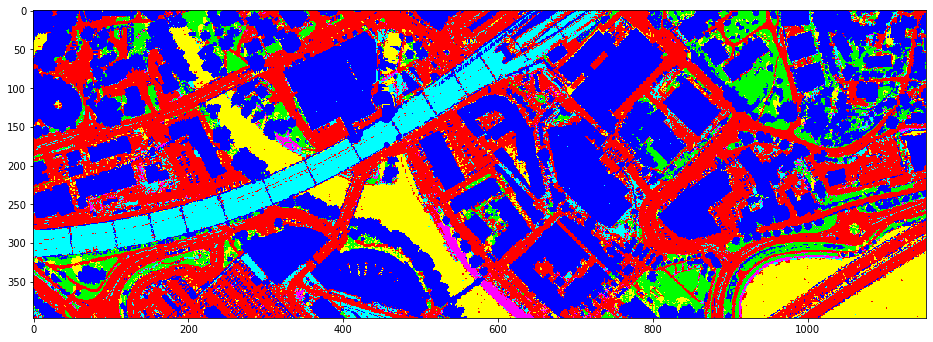

In [73]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [74]:
road = (predicted_hsi_lidar_mask == 1).astype(int)

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.feature import canny
from skimage.viewer import ImageViewer
edges = canny(
    image=road,
    sigma=5.5,
    low_threshold=0.1,
    high_threshold=0.4,
)
road_edges = edges.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1416.0]
    G: [0.0, 1295.0]
    B: [0.0, 1032.0]
>

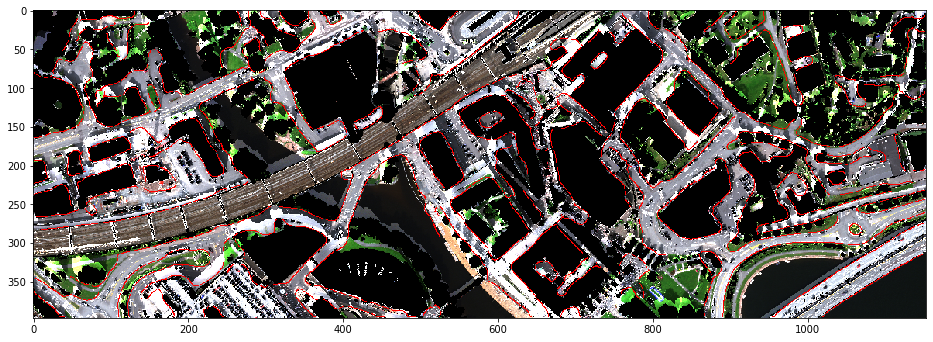

In [76]:
view = imshow(image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=road_edges)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

# Validation


In [77]:
main_df = pd.read_csv('../../hyperImage/csv/features/Stacked_HSI_feature_val1')
point_cloud_val= pd.read_csv('../../hyperImage/csv/features/Stacked_lidar_features_val1')
df_lid_hsi = pd.concat([main_df, df_ndvi_val, point_cloud_val], axis=1, sort=False)
df_lid_hsi

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC65,PC66,PC67,PC68,PC69,PC70,PC71,NDVI,Lidar Intensity,Lidar nDSM
0,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,-0.422678,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086,0.000000,16.0,29.960000
1,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,-0.422678,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086,0.000000,15.0,29.940000
2,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,-0.422678,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086,0.000000,16.0,29.940000
3,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,-0.422678,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086,0.000000,19.0,29.910000
4,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,-0.422678,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086,0.000000,17.0,29.920000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336181,-10955.795116,6039.595995,4891.547657,-2445.342462,7582.960443,-1434.890131,-476.454318,2015.559349,1909.808587,2430.330381,...,177.089701,-9.817050,41.928247,-35.437209,5.703321,-27.045144,10.401062,-0.007535,23.0,0.009999
336182,-9836.259876,5022.531363,4769.039880,-3206.856126,6536.374603,-1720.812448,324.660772,930.568527,759.102566,428.407515,...,189.734840,-17.334349,40.927541,-21.141926,16.544124,-36.275199,9.149798,0.008403,25.0,0.010000
336183,-6387.020876,6970.377627,7963.717546,-3436.109274,8568.657306,-3734.720215,3259.079433,-2127.672207,-546.795593,-1668.729675,...,8.247761,14.548043,-0.628511,8.716740,11.311020,-24.581857,1.274968,-0.007376,23.0,0.090000
336184,-7049.361874,7138.640258,8891.728496,-3161.313079,8388.955776,-3770.933546,1610.705315,-51.314330,249.440996,-492.486463,...,45.198406,7.209419,22.115634,7.394622,8.388109,-7.954778,1.574247,-0.011854,19.0,0.040001


In [78]:
X_data_scaled = scaler3.transform(df_lid_hsi)

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (76, 46, 21)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 849.0]
    G: [0.0, 825.0]
    B: [0.0, 626.0]
>

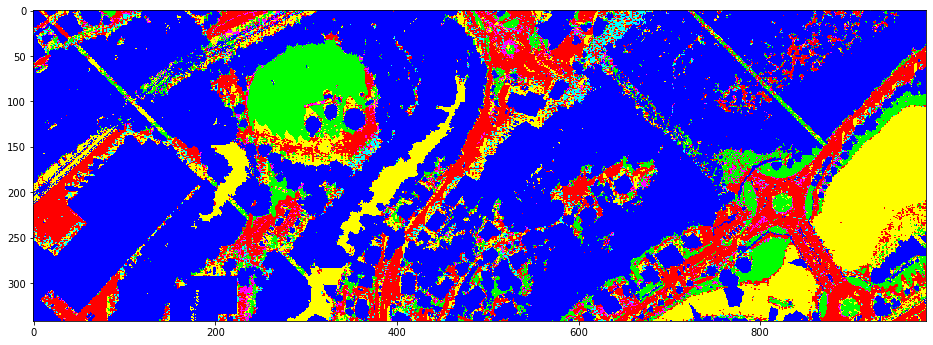

In [80]:
val_pred_full = clf2.predict(X_data_scaled)
predicted_hsi_lidar_mask_val = val_pred_full.reshape(val_image.shape[0], val_image.shape[1])
view = imshow(val_image, (76, 46, 21), stretch=((0.0, 0.9), (0.0, 0.9), (0.0, 0.9)),figsize=(16, 16), classes=predicted_hsi_lidar_mask_val)
view.set_display_mode('overlay')
view.class_alpha = 1
view.show_data

In [81]:
df_val = pd.concat([df_lid_hsi, df_class_val], axis=1, sort=False)



In [82]:
df_val

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC66,PC67,PC68,PC69,PC70,PC71,NDVI,Lidar Intensity,Lidar nDSM,Target
0,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086,0.000000,16.0,29.960000,0
1,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086,0.000000,15.0,29.940000,0
2,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086,0.000000,16.0,29.940000,0
3,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086,0.000000,19.0,29.910000,0
4,17165.675664,-3972.038444,-2404.834289,-566.960602,-498.795311,176.499534,-129.140864,30.450233,34.952119,32.885730,...,-0.049231,-0.249895,0.229616,-0.125105,0.078513,0.063086,0.000000,17.0,29.920000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336181,-10955.795116,6039.595995,4891.547657,-2445.342462,7582.960443,-1434.890131,-476.454318,2015.559349,1909.808587,2430.330381,...,-9.817050,41.928247,-35.437209,5.703321,-27.045144,10.401062,-0.007535,23.0,0.009999,0
336182,-9836.259876,5022.531363,4769.039880,-3206.856126,6536.374603,-1720.812448,324.660772,930.568527,759.102566,428.407515,...,-17.334349,40.927541,-21.141926,16.544124,-36.275199,9.149798,0.008403,25.0,0.010000,0
336183,-6387.020876,6970.377627,7963.717546,-3436.109274,8568.657306,-3734.720215,3259.079433,-2127.672207,-546.795593,-1668.729675,...,14.548043,-0.628511,8.716740,11.311020,-24.581857,1.274968,-0.007376,23.0,0.090000,0
336184,-7049.361874,7138.640258,8891.728496,-3161.313079,8388.955776,-3770.933546,1610.705315,-51.314330,249.440996,-492.486463,...,7.209419,22.115634,7.394622,8.388109,-7.954778,1.574247,-0.011854,19.0,0.040001,0


In [83]:
df_masked_val = df_val[(df_val[['Target']] != 0).all(axis=1)]
X_val = df_masked_val.drop(columns=['Target']).values
y_val = df_masked_val['Target'].values

In [84]:
X_data_scaled_val = scaler3.transform(X_val)
val_pred_full_ = clf2.predict(X_data_scaled_val)

In [85]:
accuracy_score(y_val, val_pred_full_)

0.783011749487981

In [86]:
target_names = ['Road', 'Vegetation','Water', 'Unclassified', 'Soil', 'Train Track']
print(classification_report(y_val, val_pred_full_, target_names=target_names))

              precision    recall  f1-score   support

        Road       0.92      0.92      0.92      3456
  Vegetation       0.98      0.62      0.76      5566
       Water       0.58      0.99      0.73      4439
Unclassified       0.94      0.82      0.88      4135
        Soil       0.42      0.05      0.09       940
 Train Track       0.07      0.83      0.14        18

    accuracy                           0.78     18554
   macro avg       0.65      0.71      0.59     18554
weighted avg       0.83      0.78      0.78     18554



In [87]:
cohen_kappa_score(y_val, val_pred_full_)

0.7167261514008278

In [88]:
confusion_matrix(y_val, val_pred_full_)

array([[3177,    9,   15,   95,   62,   98],
       [  33, 3467, 1967,   91,    3,    5],
       [   2,    0, 4412,   24,    0,    1],
       [  13,    0,  709, 3410,    1,    2],
       [ 226,   58,  507,   21,   47,   81],
       [   2,    0,    0,    1,    0,   15]])